In [1]:
import os,sys,time
smodelsPath = os.path.expanduser('~/smodels')
sys.path.append(smodelsPath)
from smodels.experiment.databaseObj import Database
from smodels.tools.physicsUnits import GeV
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
db = Database(os.path.abspath('../../../../'))

In [3]:
exp = db.getExpResults(analysisIDs = 'CMS-EXO-13-006-trim', dataTypes = 'efficiencyMap')[0]
print(exp)

CMS-EXO-13-006-trim: c000,c100,c200,c300(4):THSCPM1b,THSCPM2b,THSCPM3,THSCPM4,THSCPM5,THSCPM6,THSCPM7,THSCPM8,THSCPM9(9)


### Use the trimmed database to interpolate over all original map points

In [4]:
t0 = time.time()
datasetNames = ['c000','c100','c200','c300']
txNames = ['THSCPM1b','THSCPM2b','THSCPM3','THSCPM4','THSCPM5', 'THSCPM6','THSCPM7','THSCPM8','THSCPM9']

resultsDict = {}
massDict = {}
for tx in txNames:
        
    resultsDict[tx] = []  
    massDict[tx] = []
    print(tx)
    for ds in datasetNames:
#         print(tx,ds)
        dataset = [dds for dds in exp.datasets if dds.dataInfo.dataId == ds][0]
        txname = [t for t in dataset.txnameList if t.txName == tx]
        if not txname:
            continue
        txname = txname[0]
        results = []
        massList = []

        data = np.genfromtxt('%s_efficiencyMaps_%s.dat' %(tx,ds),names=True)
        #For maps without the width information use only the zero width points in the original maps
#         if tx in ['THSCPM5', 'THSCPM6','THSCPM7']:
#             data = data[data['width'] == data['width'].min()]
                    
        
        for pt in data:
            massList.append([pt[mlabel] for mlabel in ['mprod','mint','mhscp'] if mlabel in data.dtype.names])
            masses = [pt[mlabel]*GeV for mlabel in ['mprod','mint','mhscp'] if mlabel in data.dtype.names]
#             if max(masses) > 3000*GeV:continue
            width = 0.0
            if 'width' in data.dtype.names:
                width = pt['width']
             
            mass = masses[:]            
            mass[-1] = tuple([mass[-1],width*GeV])
            if tx == 'THSCPM7':
                mass = [mass[:],[mass[0],mass[-1]]]
            else:
                mass = [mass]*2

            eff = pt[ds]
            effInterp = txname.txnameData.getValueFor(mass)
            #Apply reweighting for these topologies:
            if tx in ['THSCPM5', 'THSCPM6','THSCPM7']:
                widths = []
                for ibr,br in enumerate(mass):
                    widths.append([])
                    for iw,w in enumerate(br):
                        if isinstance(w,tuple):
                            widths[ibr].append(w[1])
                        else:
                            widths[ibr].append(float('inf')*GeV)
                reweightFactor = txname.txnameData.reweightF(widths)
                effInterp *= reweightFactor
                
            results.append([eff,effInterp,width])
            
        
        resultsDict[tx] += results
        massDict[tx] += massList
print('Done in %1.2f min' %((time.time()-t0)/60))

THSCPM1b
THSCPM2b
THSCPM3
THSCPM4
THSCPM5
THSCPM6
THSCPM7
THSCPM8
THSCPM9
Done in 5.52 min


### Verify convex hull (there should be no points outside the grid)

In [5]:
for tx in resultsDict:
    resultsDict[tx] = np.array(resultsDict[tx])
    massDict[tx] = np.array(massDict[tx])
    print(tx,'# points outside the grid:',len(np.where(resultsDict[tx][:,1] == None)[0]))

THSCPM1b # points outside the grid: 0
THSCPM2b # points outside the grid: 0
THSCPM3 # points outside the grid: 0
THSCPM4 # points outside the grid: 0
THSCPM5 # points outside the grid: 0
THSCPM6 # points outside the grid: 0
THSCPM7 # points outside the grid: 0
THSCPM8 # points outside the grid: 0
THSCPM9 # points outside the grid: 0


### Compute relative difference for each topology

In [6]:
relDiffDict = {}
for tx,results in resultsDict.items():
    relDiffDict[tx] = np.zeros(len(results))
    relDiffDict[tx] = np.divide(np.abs(results[:,1]-results[:,0]),results[:,0],where=(results[:,0]>0),
                                out=relDiffDict[tx])

<ipython-input-6-1be577fbffd2>:4: RuntimeWarning: overflow encountered in true_divide
  relDiffDict[tx] = np.divide(np.abs(results[:,1]-results[:,0]),results[:,0],where=(results[:,0]>0),


### Plot the difference

/home/lessa/.local/lib/python3.8/site-packages/matplotlib/ticker.py:2313: RuntimeWarning: overflow encountered in double_scalars
  base ** np.ceil(np.log(x) / np.log(base)))
/home/lessa/.local/lib/python3.8/site-packages/matplotlib/axes/_base.py:2437: RuntimeWarning: invalid value encountered in double_scalars
  i1 = stickies.searchsorted(x1 - tol(x1))


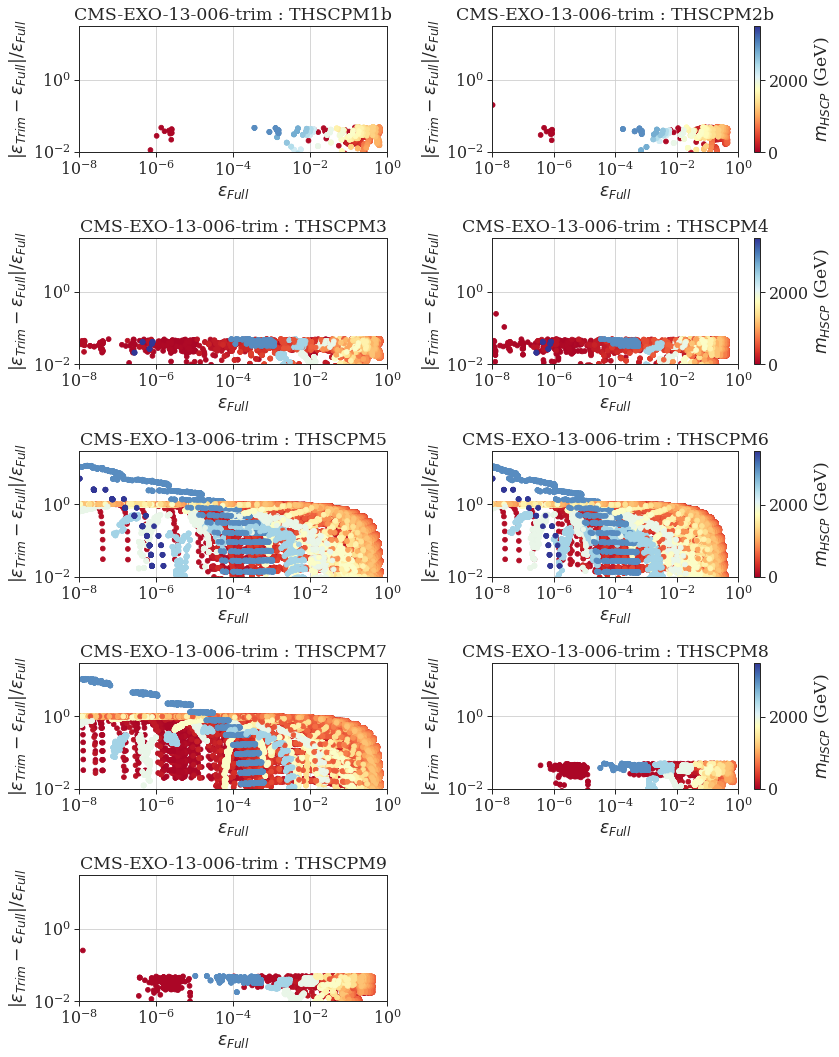

In [7]:
nr = len([tx for tx in relDiffDict if relDiffDict[tx].max() > 1e-4])
fig,ax = plt.subplots(nrows = int(np.ceil(nr/2.0)),ncols=2,figsize = (12,15),sharex=False)
i = 0
j = 0
for tx in relDiffDict:
    
    cond = massDict[tx][:,-1] > 0
    xpts = resultsDict[tx][cond][:,0]
    ypts = relDiffDict[tx][cond]
#     zpts = (massDict[tx][cond][:,-min(2,len(massDict[tx][0]))]-massDict[tx][cond][:,-1])
    zpts = massDict[tx][cond][:,-1]
    
    axx = ax[i,j].scatter(xpts,ypts,c=zpts,vmin=0.0,vmax=3500,cmap=cm)
    ax[i,j].set_yscale('log')
    ax[i,j].set_xscale('log')
    ax[i,j].set_ylim(1e-2,3e1)
    ax[i,j].set_xlim(1e-8,1)
#     ax[i,j].set_xticks(np.logspace(-3,3,16))
#     ax[i,j].text(1e-3,3e4,'%s : max diff = %1.1f %%' %(tx,100*(relDiffDict[tx].max())))
    ax[i,j].set_title('%s : %s' %(exp.globalInfo.id,tx))
    ax[i,j].set_xlabel(r'$\epsilon_{Full}$')
    ax[i,j].set_ylabel(r'$|\epsilon_{Trim}-\epsilon_{Full}|/\epsilon_{Full}$')
    ax[i,j].grid()    
    j += 1
    if j >= ax.shape[1]:
        cb = fig.colorbar(axx, ax=ax[i,j-1],label=r'$m_{HSCP}$ (GeV)')
        i += 1
        j =0
        
if j == 1:
    ax[i,1].set_axis_off()
        
plt.tight_layout()

plt.savefig('databaseCheck.png')
plt.show()



In [8]:
relDiffDict2 = {}
for tx,results in resultsDict.items():
    relDiffDict2[tx] = np.zeros(len(results))
    relDiffDict2[tx] = np.divide(np.abs(results[:,1]-results[:,0]),results[:,1],where=(results[:,1]>0),
                                out=relDiffDict2[tx])

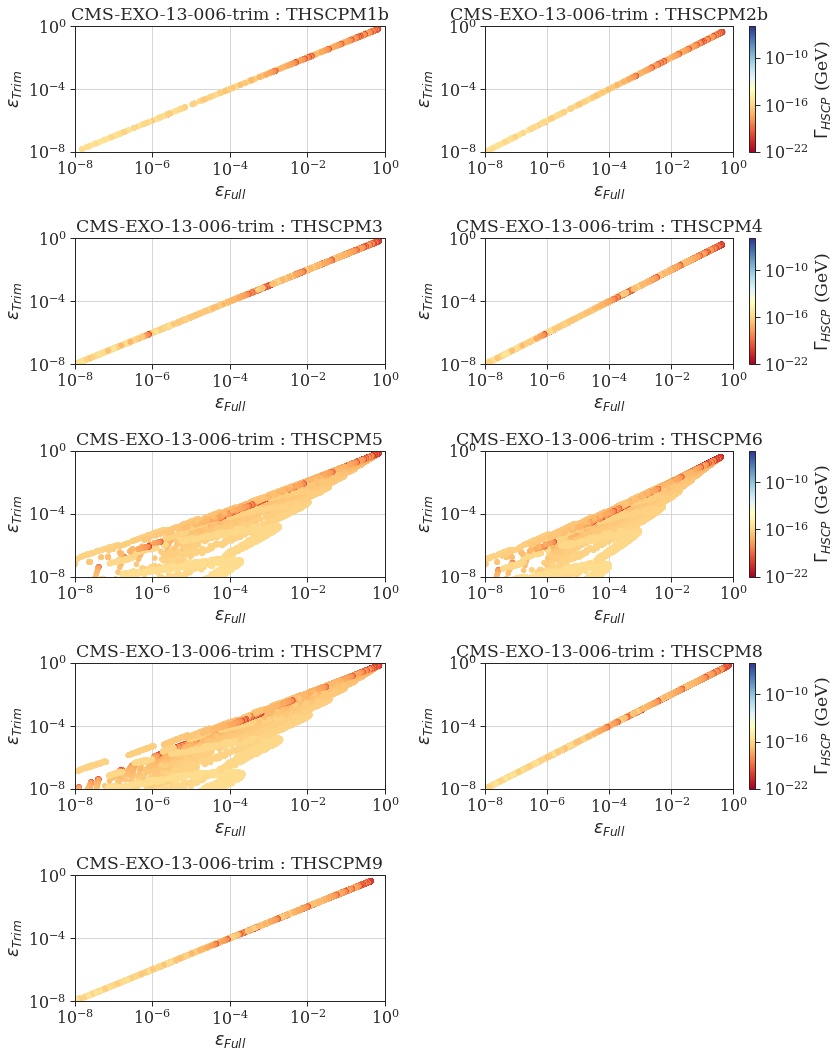

In [9]:
nr = len([tx for tx in relDiffDict2 if relDiffDict2[tx].max() > 1e-4])
fig,ax = plt.subplots(nrows = int(np.ceil(nr/2.0)),ncols=2,figsize = (12,15),sharex=False)
i = 0
j = 0
for tx in relDiffDict:
    
    cond = massDict[tx][:,-1] > 0
    xpts = resultsDict[tx][cond][:,0]
    ypts = resultsDict[tx][cond][:,1]
#     zpts = (massDict[tx][cond][:,-min(2,len(massDict[tx][0]))]-massDict[tx][cond][:,-1])
#     zpts = massDict[tx][cond][:,-1]
    zpts = resultsDict[tx][cond][:,2]
    
    axx = ax[i,j].scatter(xpts,ypts,c=zpts,vmin=1e-22,vmax=1e-6,cmap=cm,norm=LogNorm(1e-22,1e-6))
    ax[i,j].set_yscale('log')
    ax[i,j].set_xscale('log')
    ax[i,j].set_ylim(1e-8,1)
    ax[i,j].set_xlim(1e-8,1)
#     ax[i,j].set_xticks(np.logspace(-3,3,16))
#     ax[i,j].text(1e-3,3e4,'%s : max diff = %1.1f %%' %(tx,100*(relDiffDict[tx].max())))
    ax[i,j].set_title('%s : %s' %(exp.globalInfo.id,tx))
    ax[i,j].set_xlabel(r'$\epsilon_{Full}$')
    ax[i,j].set_ylabel(r'$\epsilon_{Trim}$')
    ax[i,j].grid()    
    j += 1
    if j >= ax.shape[1]:
        cb = fig.colorbar(axx, ax=ax[i,j-1],label=r'$\Gamma_{HSCP}$ (GeV)')
        i += 1
        j =0
        
if j == 1:
    ax[i,1].set_axis_off()
        
plt.tight_layout()

plt.savefig('databaseCheck2.png')
plt.show()

